# Foot Traffic in Würzburg
***Celina Fitzpatrick (2206514), Philipp Orf (1807836), Hannah Schönborn (2873730)***


**This script deploys predictive machine learning models capable of accurately forecasting future foot traffic on three streets in the city of Wuerzburg, Germany.**

The task involves predicting three variables: the total hourly pedestrian count ("n_pedestrians"), the number of pedestrians per hour heading towards the city center ("n_pedestrians_towards"), and the number of pedestrians per hour leaving the city center ("n_pedestrians_away"). Model performance will be assessed by the Mean Squared Error (MSE) metric to evaluate accuracy and compare models. We use a scikit-learn pipeline for consistent model implementation.


## Table of Contents
1) **[Data Import and First Insights](#chapter1)**
2) **[Exploratory Data Analysis](#chapter2)**
   * [Time Series Plots](#section_2_1)
   * [Boxplots and Barcharts](#section_2_2)
   * [Autocorrelation Function Plot and Time Series Decomposition](#section_2_3)
3) **[Data Preprocessing and Feature Engineering](#chapter3)**
   * [Add Regional and School Holidays via an API](#section_3_1)
   * [Section Events Within the City](#section_3_2)
   * [Create 'holiday_with_weekends' Feature](#section_2_1)
4) **[Instantiate The Pedestrian Model Pipeline Class](#chapter4)**
   * [Class Definition](#section_4_1)
   * [Application of the Pipeline for Model Predictions](#section_4_2)
5) **[Results Interpretation](#chapter5)**
   * [Feature Importance](#section_5_1)
   * [View Solution Dataset](#section_5_2)
6) **[Appendix](#chapter6)**
   * [Check Presence of Events in the Test Dataset](#section_6_1)
   * [Check Presence of Holidays with Adjacent Weekends in the Test Dataset](#section_6_2)
   * [Save requirements.txt](#section_6_3)


## Data Import and First Insights

In [3]:
import kagglehub
import numpy as np
import pandas as pd

kagglehub.login()

In [4]:
# IMPORT YOUR KAGGLE DATA SOURCES

ftwue_path = kagglehub.competition_download('foot-traffic-wue')
pipeline_and_features_path = kagglehub.dataset_download('hannahsborn/pipeline-and-features')

print('Data source import complete.')

Data source import complete.


In [5]:
# Check available kernels

!jupyter kernelspec list

Available kernels:
  ir         /usr/local/share/jupyter/kernels/ir
  python3    /usr/local/share/jupyter/kernels/python3


In [6]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pipeline-and-features/events_by_month.csv
/kaggle/input/pipeline-and-features/street_facilities.csv
/kaggle/input/pipeline-and-features/bavarian_school_holidays.csv
/kaggle/input/pipeline-and-features/one_day_events.csv
/kaggle/input/pipeline-and-features/multi_day_events.csv
/kaggle/input/pipeline-and-features/bavarian_public_holidays.csv
/kaggle/input/foot-traffic-wue/solutionPublicLeaderboard.csv
/kaggle/input/foot-traffic-wue/sample_submission.csv
/kaggle/input/foot-traffic-wue/counterGeoLocations.json
/kaggle/input/foot-traffic-wue/train.csv
/kaggle/input/foot-traffic-wue/test.csv


In [7]:
sample_submission = pd.read_csv(f'{ftwue_path}/sample_submission.csv')
sample_submission

,id,n_pedestrians,n_pedestrians_towards,n_pedestrians_away
0,Schoenbornstrasse_2024-09-16_0,85.032614,40.935775,44.096839
1,Schoenbornstrasse_2024-09-16_1,46.097341,23.102860,22.994481
2,Schoenbornstrasse_2024-09-16_2,28.070926,14.138330,13.932596
3,Schoenbornstrasse_2024-09-16_3,21.362770,10.902659,10.460110
4,Schoenbornstrasse_2024-09-16_4,19.870045,8.812845,11.057200
...,...,...,...,...
1003,Kaiserstrasse_2024-09-29_19,1162.651811,551.877437,610.774373
1004,Kaiserstrasse_2024-09-29_20,605.877437,278.065460,327.811978
1005,Kaiserstrasse_2024-09-29_21,396.770195,178.065460,218.704735
1006,Kaiserstrasse_2024-09-29_22,305.189415,130.176880,175.012535


In [8]:
train_df = pd.read_csv(f'{ftwue_path}/train.csv')
train_df.head(2)

,id,streetname,city,date,hour,weekday,n_pedestrians,n_pedestrians_towards,n_pedestrians_away,temperature,weather_condition,incidents,collection_type
0,Schoenbornstrasse_2019-04-02_18,Schoenbornstrasse,Wuerzburg,2019-04-02,18,Tuesday,1324,682,642,18,partly-cloudy-day,no_incident,measured
1,Schoenbornstrasse_2019-04-02_19,Schoenbornstrasse,Wuerzburg,2019-04-02,19,Tuesday,1406,708,698,16,partly-cloudy-day,no_incident,measured


In [9]:
# View initial columns
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82821 entries, 0 to 82820
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     82821 non-null  object
 1   streetname             82821 non-null  object
 2   city                   82821 non-null  object
 3   date                   82821 non-null  object
 4   hour                   82821 non-null  int64 
 5   weekday                82821 non-null  object
 6   n_pedestrians          82821 non-null  int64 
 7   n_pedestrians_towards  82821 non-null  int64 
 8   n_pedestrians_away     82821 non-null  int64 
 9   temperature            82821 non-null  int64 
 10  weather_condition      82821 non-null  object
 11  incidents              82821 non-null  object
 12  collection_type        82821 non-null  object
dtypes: int64(5), object(8)
memory usage: 8.2+ MB


In [10]:
test_df = pd.read_csv(f'{ftwue_path}/test.csv')

test_df['date'] = pd.to_datetime(test_df['date'])  
test_df.head(2)

,id,streetname,city,date,hour,weekday,temperature,weather_condition,incidents,collection_type
0,Schoenbornstrasse_2024-09-16_0,Schoenbornstrasse,Wuerzburg,2024-09-16,0,Monday,12,cloudy,no_incident,measured
1,Schoenbornstrasse_2024-09-16_1,Schoenbornstrasse,Wuerzburg,2024-09-16,1,Monday,12,cloudy,no_incident,measured


In [11]:
# View initial columns
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1008 non-null   object        
 1   streetname         1008 non-null   object        
 2   city               1008 non-null   object        
 3   date               1008 non-null   datetime64[ns]
 4   hour               1008 non-null   int64         
 5   weekday            1008 non-null   object        
 6   temperature        1008 non-null   int64         
 7   weather_condition  1008 non-null   object        
 8   incidents          1008 non-null   object        
 9   collection_type    1008 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 78.9+ KB


In [12]:
json_locations = open(f'{ftwue_path}/counterGeoLocations.json', 'r')
print(json_locations.read())
json_locations.close()

[{"id": 476, "counter_street_name": "Kaiserstra\u00dfe", "city": "W\u00fcrzburg", "geo_shape": {"type": "Feature", "geometry": {"coordinates": [[[9.933534264564514, 49.79767989935027], [9.934167265892029, 49.79879140391002], [9.934676885604858, 49.79962588121911], [9.934483766555786, 49.79967089410911], [9.933979511260986, 49.798832954987645], [9.9334055185318, 49.79787727118186], [9.933443069458008, 49.797859957895504], [9.933362603187561, 49.797742227384], [9.93313193321228, 49.79776300337743], [9.93312656879425, 49.79773876471757], [9.933255314826965, 49.79744443716551], [9.933432340621948, 49.79751715355065], [9.933518171310425, 49.79751369086812], [9.933534264564514, 49.79767989935027]]], "type": "Polygon"}, "properties": {}}, "geo_point_2d": {"lon": 9.933887635731686, "lat": 49.798498976405355}},{"id": 470, "counter_street_name": "Spiegelstra\u00dfe", "city": "W\u00fcrzburg", "geo_shape": {"type": "Feature", "geometry": {"coordinates": [[[9.934698343276976, 49.7948335003235], [9.

In [13]:
# View columns
train_df.columns

Index(['id', 'streetname', 'city', 'date', 'hour', 'weekday', 'n_pedestrians',
       'n_pedestrians_towards', 'n_pedestrians_away', 'temperature',
       'weather_condition', 'incidents', 'collection_type'],
      dtype='object')

In [14]:
#print out every unique value per column
for col in train_df.columns:
    unique_values = train_df[col].unique()
    print(f"{col}: {unique_values}")

id: ['Schoenbornstrasse_2019-04-02_18' 'Schoenbornstrasse_2019-04-02_19'
 'Schoenbornstrasse_2019-04-02_20' ... 'Kaiserstrasse_2024-09-15_21'
 'Kaiserstrasse_2024-09-15_22' 'Kaiserstrasse_2024-09-15_23']
streetname: ['Schoenbornstrasse' 'Spiegelstrasse' 'Kaiserstrasse']
city: [' Wuerzburg']
date: ['2019-04-02' '2019-04-03' '2019-04-04' ... '2024-09-13' '2024-09-14'
 '2024-09-15']
hour: [18 19 20 21 22 23  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
weekday: ['Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday']
n_pedestrians: [1324 1406  676 ... 4510 3303 2880]
n_pedestrians_towards: [ 682  708  348 ... 2792 2893 2723]
n_pedestrians_away: [ 642  698  328 ... 2574 2660 1696]
temperature: [ 18  16  15  14  12  10  13  11   9   8   5   6   4   7  19  17   3   2
   0   1  -1  20  21  22  23  24  26  25  27  28  29  30  31  33  32  34
  35  36  37  38  39  -2  -3  -4  -5  -6  -7  -8  -9 -10 -11 -12 -13 -14
 -15]
weather_condition: ['partly-cloudy-day' 'partly-clo

## Exploratory Data Analysis


### Time Series Plots

**Ensuring data coverage by street**

In [15]:
data = train_df.copy()

# Dictionary to store the full time series DataFrame for each streetname combination
street_time_series_dict = {}

# Iterate over each group and store the full DataFrame as the time series
for streetname, group in data.groupby('streetname'):  # Group only by 'streetname', no tuple
    # Sort the group by 'date' to ensure chronological order
    group = group.sort_values(by='date')

    # Include both 'n_pedestrians_towards' and 'n_pedestrians_away' in the time series
    time_series_df = group[['date', 'n_pedestrians_towards', 'n_pedestrians_away']].copy()

    # Add a total pedestrians column
    time_series_df['total_pedestrians'] = group['n_pedestrians_towards'] + group['n_pedestrians_away']

    # Store the full time series DataFrame for this streetname
    street_time_series_dict[streetname] = time_series_df

# Display an example of a time series for a specific streetname (optional)
for key, time_series in street_time_series_dict.items():
    print(f"Time series for {key}:\n", time_series.head())
    break  # Uncomment if you only want to see one street's time series

Time series for Kaiserstrasse:
              date  n_pedestrians_towards  n_pedestrians_away  \
65591  2022-09-29                     11                  46   
65614  2022-09-29                     45                  35   
65613  2022-09-29                     56                  90   
65612  2022-09-29                     84                 125   
65611  2022-09-29                    206                 223   

       total_pedestrians  
65591                 57  
65614                 80  
65613                146  
65612                209  
65611                429  


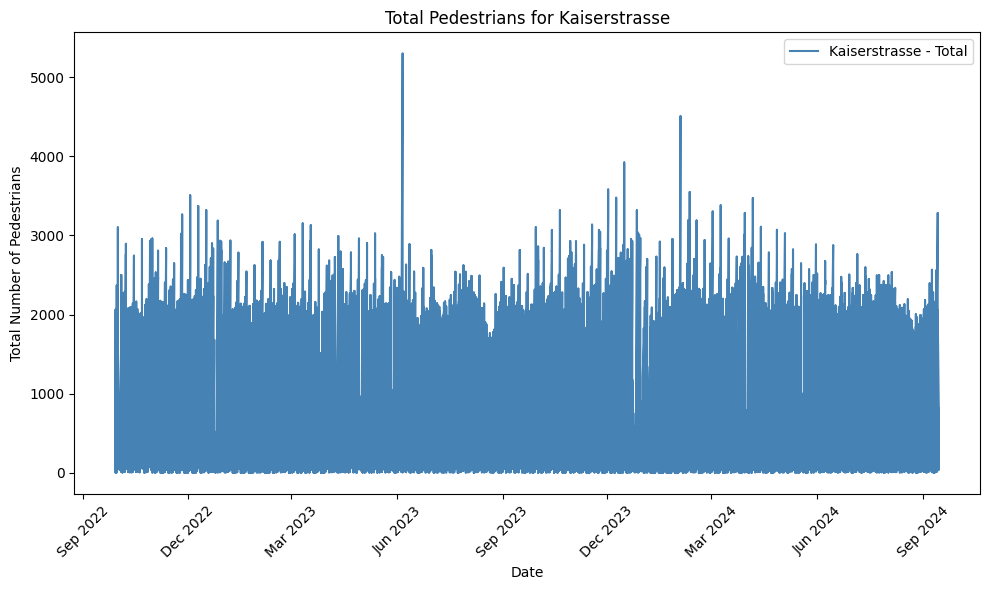

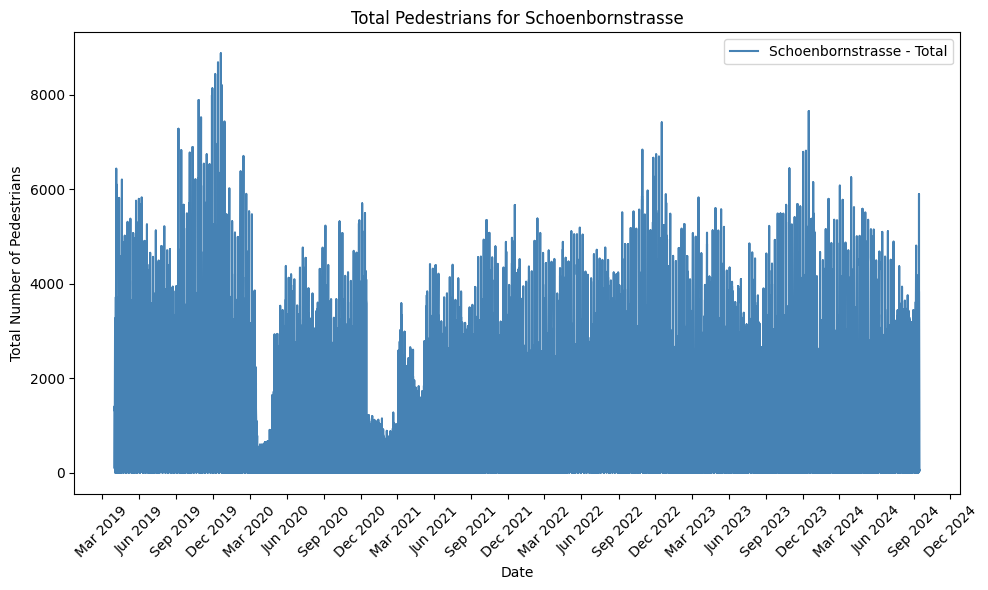

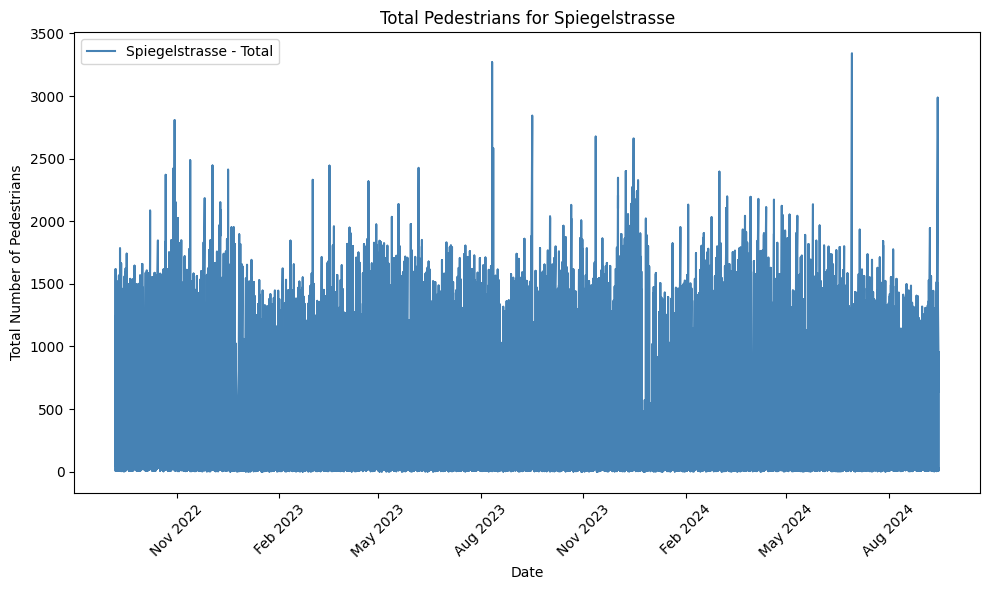

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Loop through each street and plot the total pedestrians time series
for streetname, time_series in street_time_series_dict.items():
    plt.figure(figsize=(10, 6))  # Create a new figure for each street
    
    # Ensure the 'date' column is in datetime format
    time_series['date'] = pd.to_datetime(time_series['date'])
    
    # Plot total pedestrians
    plt.plot(time_series['date'], time_series['total_pedestrians'], label=f'{streetname} - Total', color='#4682B4')  # neutral colour
    
    # Add title and labels
    plt.title(f'Total Pedestrians for {streetname}')
    plt.xlabel('Date')
    plt.ylabel('Total Number of Pedestrians')
    
    # Format the x-axis to show quarterly ticks (every 3 months)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=3))  # Every 3 months
    
    # Set the x-axis to display only the month and year (no weekdays)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Add a legend
    plt.legend()
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Show plot
    plt.show()

### Boxplots and Barcharts

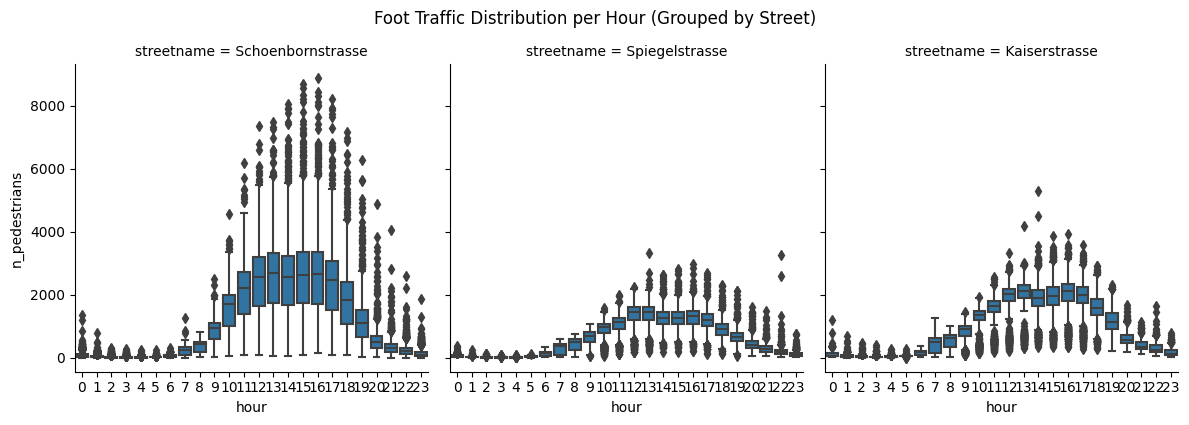

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.FacetGrid(train_df, col="streetname", col_wrap=3, height=4, sharey=True)
g.map(sns.boxplot, "hour", "n_pedestrians", order=sorted(train_df["hour"].unique()))

# Set title
g.fig.suptitle("Foot Traffic Distribution per Hour (Grouped by Street)", y=1.05)
# plt.savefig(f"allstreets_boxplot_trafficperHour.png", dpi=300, bbox_inches="tight")

plt.show()

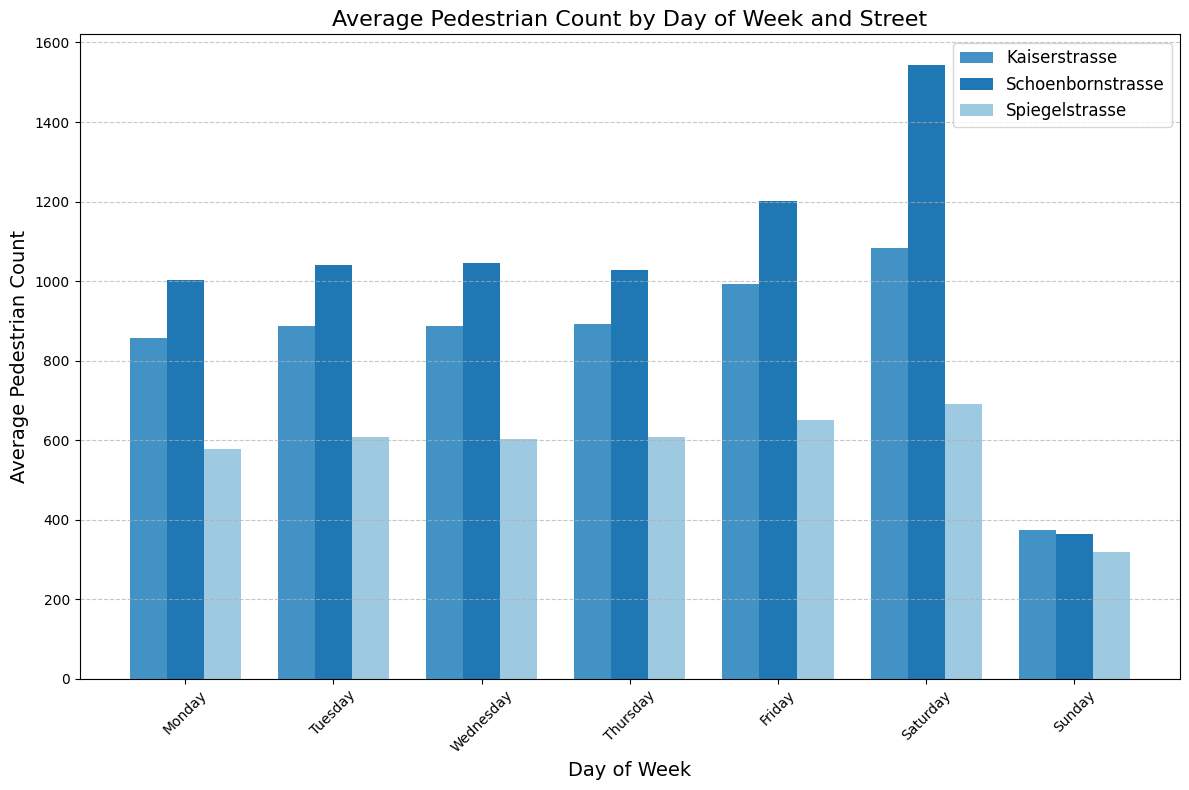

In [18]:
# Show counts by day and street

combined_df = pd.DataFrame()
for streetname, df in street_time_series_dict.items():
    temp_df = df.copy()
    temp_df['date'] = pd.to_datetime(temp_df['date'])
    temp_df['weekday'] = temp_df['date'].dt.day_name()
    temp_df['streetname'] = streetname
    combined_df = pd.concat([combined_df, temp_df])

# Weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create weekly distribution data
weekly_data = combined_df.groupby(['streetname', 'weekday'])['total_pedestrians'].mean().reset_index()
weekly_pivot = weekly_data.pivot(index='weekday', columns='streetname', values='total_pedestrians')
weekly_pivot = weekly_pivot.reindex(weekday_order) 

# Set up the figure
plt.figure(figsize=(12, 8))
plt.title('Average Pedestrian Count by Day of Week and Street', fontsize=16)
x = np.arange(len(weekday_order))
width = 0.25  # Width of the bars

# Set color palette with shades of blue
streets = combined_df['streetname'].unique()
blue_colors = ['#4292c6', '#1f77b4', '#9ecae1']  # medium blue, dark blue, light blue
street_colors = dict(zip(streets, blue_colors))

# Plot each street as a group of bars
multiplier = 0
for street in streets:
    offset = width * multiplier
    plt.bar(x + offset, weekly_pivot[street], width, label=street, color=street_colors[street])
    multiplier += 1

# Set x-axis labels
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Average Pedestrian Count', fontsize=14)
plt.xticks(x + width, weekday_order, rotation=45)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

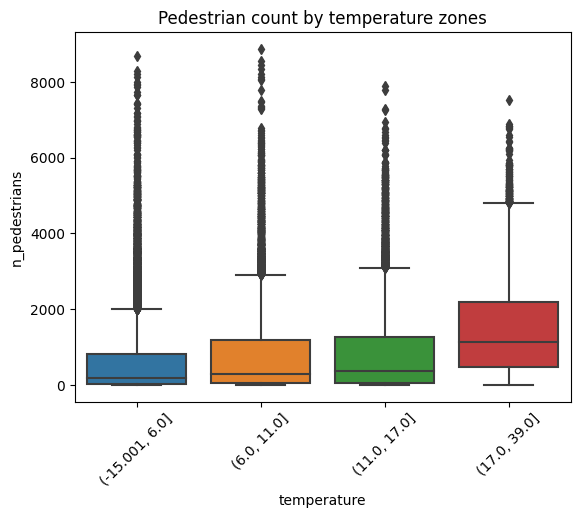

In [19]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.boxplot(x=pd.qcut(train_df["temperature"], q=4), y=train_df["n_pedestrians"])
plt.title("Pedestrian count by temperature zones")
plt.xlabel("temperature")
plt.ylabel("n_pedestrians")
plt.xticks(rotation=45)
plt.savefig(f"boxplot_temperature_n_pedestrians.png", dpi=300, bbox_inches="tight")
plt.show()

### Autocorrelation Function Plot and Time Series Decomposition

<Figure size 1000x600 with 0 Axes>

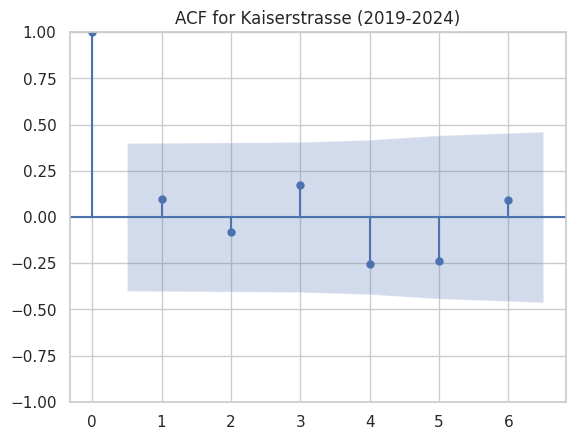

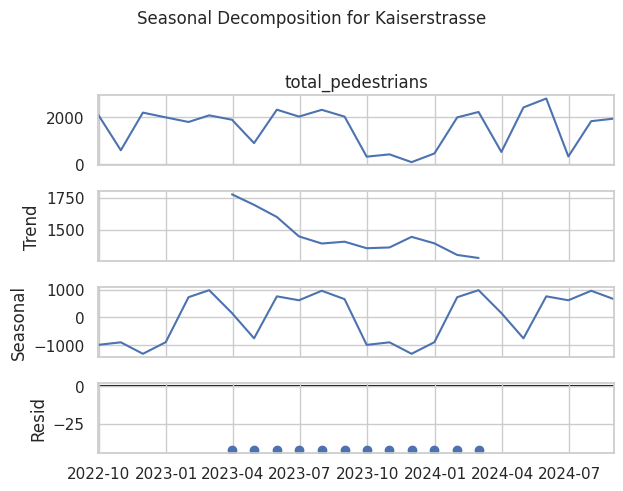

<Figure size 1000x600 with 0 Axes>

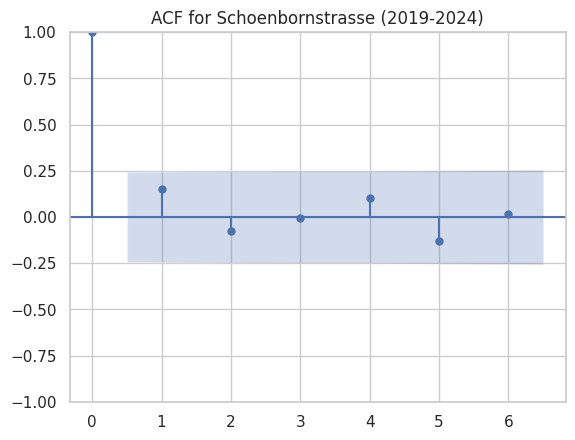

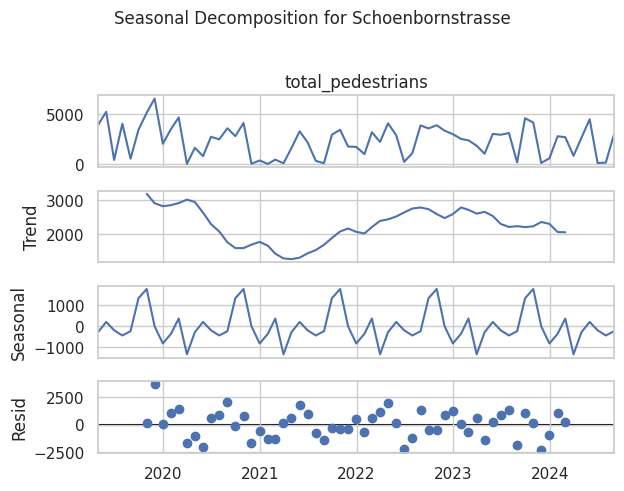

<Figure size 1000x600 with 0 Axes>

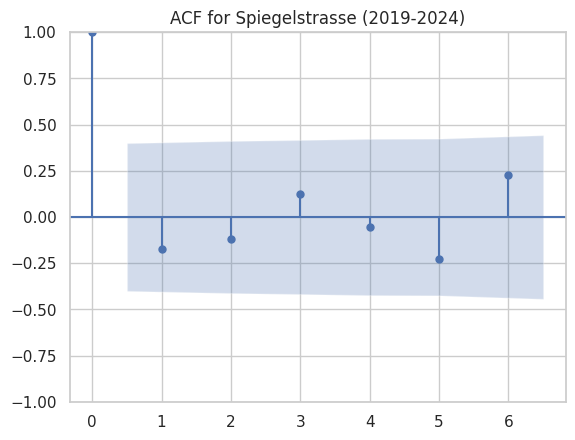

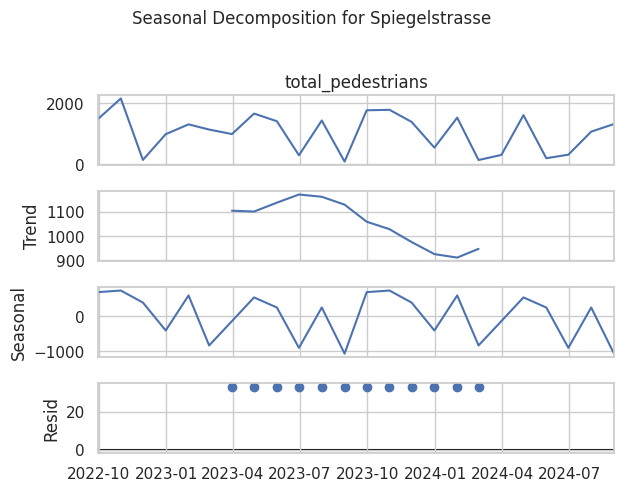

In [20]:
# Plot ACF and Seasonal Decomposition per Street

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set up seaborn style for cleaner visuals
sns.set(style="whitegrid")

for streetname, time_series in street_time_series_dict.items():
    try:
        # Prepare time series data
        time_series = street_time_series_dict[streetname]
        time_series['date'] = pd.to_datetime(time_series['date'])
        time_series.set_index('date', inplace=True)
        time_series = time_series[~time_series.index.duplicated(keep='first')]
        time_series = time_series.asfreq('ME')

        # Plot the ACF
        plt.figure(figsize=(10, 6))
        plot_acf(time_series['total_pedestrians'], lags=6)
        plt.title(f'ACF for {streetname} (2019-2024)')
        plt.show()

        # Perform seasonal decomposition for the 12 months
        decomposition = seasonal_decompose(time_series['total_pedestrians'], model='additive', period=12)

        decomposition.plot()

        plt.suptitle(f'Seasonal Decomposition for {streetname}', y=1.02, fontsize=12)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error for {streetname}: {e}")

## Data Preprocessing and Feature Engineering

### Add Regional and School Holidays via an API

In [21]:
#constans and functions to add holidays
import os
import requests
import pandas as pd
from datetime import datetime, timedelta

CSV_PATH = pipeline_and_features_path

# Constants
COUNTRY_CODE = "DE"  # Germany
SUBDIVISION_CODE = "DE-BY"  # Bavaria
LANGUAGE_CODE = "DE"
START_DATE = "2019-01-01"
END_DATE = "2024-12-31"
PUBLIC_HOLIDAY_CSV_FILE = f"{CSV_PATH}/bavarian_public_holidays.csv"
SCHOOL_HOLIDAY_CSV_FILE = f"{CSV_PATH}/bavarian_school_holidays.csv"
PUBLIC_HOLIDAY_API_URL = "https://openholidaysapi.org/PublicHolidays"
SCHOOL_HOLIDAY_API_URL = "https://openholidaysapi.org/SchoolHolidays"

def split_date_range(start_date, end_date, max_days=1095):
    """Splits a date range into chunks of at most max_days."""
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    chunks = []
    while start < end:
        chunk_end = min(start + timedelta(days=max_days), end)
        chunks.append((start.strftime("%Y-%m-%d"), chunk_end.strftime("%Y-%m-%d")))
        start = chunk_end + timedelta(days=1)  # Move to the next chunk
    
    return chunks

def fetch_public_holidays():
    """Fetch Bavarian public holidays from OpenHolidays API and save to CSV."""
    date_chunks = split_date_range(START_DATE, END_DATE)
    all_holidays = []

    for start_date, end_date in date_chunks:
        print(f"Fetching public holidays from {start_date} to {end_date}")
        params = {
            "countryIsoCode": COUNTRY_CODE,
            "languageIsoCode": LANGUAGE_CODE,
            "validFrom": start_date,
            "validTo": end_date
        }
        
        try:
            response = requests.get(PUBLIC_HOLIDAY_API_URL, params=params, headers={"accept": "application/json"})
            response.raise_for_status()  # Will raise an error for bad status codes
        except requests.exceptions.RequestException as e:
            print(f"An error occurred: {e}")
            return
        
        if response.status_code == 200:
            holidays = response.json()
            print(f"Fetched Holidays from {start_date} to {end_date}: {holidays}")  # Inspect the response
            
            formatted_holidays = []
            for holiday in holidays:
                for holiday_info in holiday.get('name', []):
                    holiday_data = {
                        "id": holiday.get('id'),
                        "startDate": holiday.get('startDate'),
                        "endDate": holiday.get('endDate'),
                        "type": holiday.get('type'),
                        "name": holiday_info.get('text') if isinstance(holiday_info, dict) else '',
                        "regionalScope": holiday.get('regionalScope'),
                        "temporalScope": holiday.get('temporalScope'),
                        "nationwide": holiday.get('nationwide'),
                        "subdivisions": ', '.join([sub['shortName'] for sub in holiday.get('subdivisions', [])]) if holiday.get('subdivisions') else ''
                    }
                    formatted_holidays.append(holiday_data)

            all_holidays.extend(formatted_holidays)

    # Save all holidays to a CSV
    df = pd.DataFrame(all_holidays)
    print(f"DataFrame: {df}")  # Check the dataframe
    df.to_csv(PUBLIC_HOLIDAY_CSV_FILE, index=False)
    print("Public holidays saved to CSV.")

def fetch_school_holidays():
    """Fetch Bavarian school holidays from OpenHolidays API and save to CSV."""
    date_chunks = split_date_range(START_DATE, END_DATE)
    all_school_holidays = []

    for start_date, end_date in date_chunks:
        print(f"Fetching school holidays from {start_date} to {end_date}")
        params = {
            "countryIsoCode": COUNTRY_CODE,
            "subdivisionCode": SUBDIVISION_CODE,
            "languageIsoCode": LANGUAGE_CODE,
            "validFrom": start_date,
            "validTo": end_date
        }

        try:
            response = requests.get(SCHOOL_HOLIDAY_API_URL, params=params, headers={"accept": "application/json"})
            response.raise_for_status()  # Will raise an error for bad status codes
        except requests.exceptions.RequestException as e:
            print(f"An error occurred: {e}")
            return

        if response.status_code == 200:
            school_holidays = response.json()
            print(f"Fetched School Holidays from {start_date} to {end_date}: {school_holidays}")  # Inspect the response
            
            formatted_school_holidays = []
            for school_holiday in school_holidays:
                for holiday_info in school_holiday.get('name', []):
                    school_holiday_data = {
                        "id": school_holiday.get('id'),
                        "startDate": school_holiday.get('startDate'),
                        "endDate": school_holiday.get('endDate'),
                        "name": holiday_info.get('text') if isinstance(holiday_info, dict) else school_holiday.get('name'),
                        "type": school_holiday.get('type'),
                        "subdivisions": ', '.join([sub['shortName'] for sub in school_holiday.get('subdivisions', [])]) if school_holiday.get('subdivisions') else ''
                    }
                    formatted_school_holidays.append(school_holiday_data)

            all_school_holidays.extend(formatted_school_holidays)

    # Save all school holidays to a CSV
    df = pd.DataFrame(all_school_holidays)
    print(f"DataFrame: {df}")  # Check the dataframe
    df.to_csv(SCHOOL_HOLIDAY_CSV_FILE, index=False)
    print("School holidays saved to CSV.")

def load_or_fetch_holidays():
    """Load public and school holidays from CSV if available; otherwise, fetch from API."""
    # Fetch or load public holidays
    if os.path.exists(PUBLIC_HOLIDAY_CSV_FILE):
        print("Loading public holidays from CSV...")
        public_holidays_df = pd.read_csv(PUBLIC_HOLIDAY_CSV_FILE)
    else:
        print("Public holidays CSV file not found. Fetching from API...")
        fetch_public_holidays()
        public_holidays_df = pd.read_csv(PUBLIC_HOLIDAY_CSV_FILE)

    # Fetch or load school holidays
    if os.path.exists(SCHOOL_HOLIDAY_CSV_FILE):
        print("Loading school holidays from CSV...")
        school_holidays_df = pd.read_csv(SCHOOL_HOLIDAY_CSV_FILE)
    else:
        print("School holidays CSV file not found. Fetching from API...")
        fetch_school_holidays()
        school_holidays_df = pd.read_csv(SCHOOL_HOLIDAY_CSV_FILE)

    return public_holidays_df, school_holidays_df

In [22]:
# Load or fetch holidays
public_holidays_df, school_holidays_df = load_or_fetch_holidays()

# Print both public and school holidays data
print("Public Holidays:")
public_holidays_df.head(2)

Loading public holidays from CSV...
Loading school holidays from CSV...
Public Holidays:


,id,startDate,endDate,type,name,regionalScope,temporalScope,nationwide,subdivisions
0,bff5aa15-d762-471c-b98a-f97a88f02fa3,2020-01-01,2020-01-01,Public,Neujahr,Regional,FullDay,True,NaN
1,acdc4a9a-3ca7-4629-86a2-2fde04e93e8d,2020-01-06,2020-01-06,Public,Heilige Drei Könige,Regional,FullDay,False,"BW, BY, ST"


In [23]:
school_holidays_df.head(2)

,id,startDate,endDate,name,type,subdivisions
0,3c508482-faa7-4fe8-b80b-bb7f33dcc4ef,2019-12-23,2020-01-04,Weihnachtsferien,School,BY
1,a570a9c7-10b8-4ee9-b4a3-268f224017d0,2020-02-24,2020-02-28,Frühjahrsferien,School,BY


In [24]:
# Load public holidays
public_holidays_df["startDate"] = pd.to_datetime(public_holidays_df["startDate"])
public_holidays_df["endDate"] = pd.to_datetime(public_holidays_df["endDate"])

# Load school holidays
school_holidays_df["startDate"] = pd.to_datetime(school_holidays_df["startDate"])
school_holidays_df["endDate"] = pd.to_datetime(school_holidays_df["endDate"])

# Add public holiday flag 
train_df["is_public_holiday"] = train_df["date"].apply(lambda x: ((public_holidays_df["startDate"] <= x) & (x <= public_holidays_df["endDate"])).any())
test_df["is_public_holiday"] = test_df["date"].apply(lambda x: ((public_holidays_df["startDate"] <= x) & (x <= public_holidays_df["endDate"])).any())

# Add school holiday flag 
train_df["is_school_holiday"] = train_df["date"].apply(lambda x: ((school_holidays_df["startDate"] <= x) & (x <= school_holidays_df["endDate"])).any())
test_df["is_school_holiday"] = test_df["date"].apply(lambda x: ((school_holidays_df["startDate"] <= x) & (x <= school_holidays_df["endDate"])).any())

In [25]:
# Test that true and false values exist
train_df["is_public_holiday"].unique()

array([False,  True])

### Add Events Within The City

In [26]:
# Events spanning more than one day

events_data = [
    # February events
    {"start_date": "2020-02-23", "end_date": "2020-02-23", "event": "Faschingszug"},
    {"start_date": "2023-02-19", "end_date": "2023-02-19", "event": "Faschingszug"},
    {"start_date": "2024-02-11", "end_date": "2024-02-11", "event": "Faschingszug"},
    
    # March events
    {"start_date": "2019-03-03", "end_date": "2019-03-03", "event": "Faschingszug"},
    {"start_date": "2019-03-30", "end_date": "2019-04-14", "event": "Frühjahrsvolksfest"},
    {"start_date": "2022-03-26", "end_date": "2022-04-10", "event": "Frühjahrsvolksfest"},
    {"start_date": "2023-03-18", "end_date": "2023-04-02", "event": "Frühjahrsvolksfest"},
    {"start_date": "2024-03-09", "end_date": "2024-03-24", "event": "Frühjahrsvolksfest"},
    
    # April events
    {"start_date": "2019-04-14", "end_date": "2019-04-14", "event": "Residenzlauf"},
    {"start_date": "2023-04-30", "end_date": "2023-04-30", "event": "Residenzlauf"},
    {"start_date": "2024-04-28", "end_date": "2024-04-28", "event": "Residenzlauf"},
    
    # May events
    {"start_date": "2022-05-01", "end_date": "2022-05-01", "event": "Residenzlauf"},
    {"start_date": "2019-05-29", "end_date": "2019-06-10", "event": "Weindorf"},
    {"start_date": "2022-05-25", "end_date": "2022-06-06", "event": "Weindorf"},
    {"start_date": "2023-05-26", "end_date": "2023-06-04", "event": "Weindorf"},
    {"start_date": "2024-05-29", "end_date": "2024-06-09", "event": "Weindorf"},
    {"start_date": "2019-05-24", "end_date": "2019-06-23", "event": "Mozartfest"},
    {"start_date": "2021-05-28", "end_date": "2021-06-27", "event": "Mozartfest"},
    {"start_date": "2022-05-20", "end_date": "2022-06-19", "event": "Mozartfest"},
    {"start_date": "2024-05-24", "end_date": "2024-06-23", "event": "Mozartfest"},
    {"start_date": "2019-05-30", "end_date": "2019-06-02", "event": "Africa Festival"},
    {"start_date": "2022-05-26", "end_date": "2022-05-29", "event": "Africa Festival"},
    {"start_date": "2023-05-26", "end_date": "2023-05-29", "event": "Africa Festival"},
    {"start_date": "2024-05-30", "end_date": "2024-06-02", "event": "Africa Festival"},
    
    # June events
    {"start_date": "2019-06-20", "end_date": "2019-06-23", "event": "Umsonst & Draussen"},
    {"start_date": "2020-06-18", "end_date": "2020-06-21", "event": "Umsonst & Draussen"},
    {"start_date": "2022-06-16", "end_date": "2022-06-19", "event": "Umsonst & Draussen"},
    {"start_date": "2023-06-08", "end_date": "2023-06-11", "event": "Umsonst & Draussen"},
    {"start_date": "2024-06-20", "end_date": "2024-06-23", "event": "Umsonst & Draussen"},
    {"start_date": "2019-06-07", "end_date": "2019-06-23", "event": "Festungsflimmern"},
    {"start_date": "2021-06-25", "end_date": "2021-07-10", "event": "Festungsflimmern"},
    {"start_date": "2022-06-30", "end_date": "2022-07-16", "event": "Festungsflimmern"},
    {"start_date": "2023-06-29", "end_date": "2023-07-15", "event": "Festungsflimmern"},
    {"start_date": "2024-06-27", "end_date": "2024-07-13", "event": "Festungsflimmern"},
    {"start_date": "2019-06-28", "end_date": "2019-07-07", "event": "Hofgarten Weinfest"},
    {"start_date": "2023-06-30", "end_date": "2023-07-09", "event": "Hofgarten Weinfest"},
    {"start_date": "2024-06-28", "end_date": "2024-07-07", "event": "Hofgarten Weinfest"},
    {"start_date": "2023-06-30", "end_date": "2023-07-16", "event": "Kiliani-Volksfest"},
    {"start_date": "2023-06-02", "end_date": "2023-07-02", "event": "Mozartfest"},
    
    # July events
    {"start_date": "2019-07-05", "end_date": "2019-07-21", "event": "Kiliani-Volksfest"},
    {"start_date": "2022-07-01", "end_date": "2022-07-17", "event": "Kiliani-Volksfest"},
    {"start_date": "2024-07-05", "end_date": "2024-07-21", "event": "Kiliani-Volksfest"},
    {"start_date": "2020-07-03", "end_date": "2020-07-19", "event": "Festungsflimmern"},
    {"start_date": "2022-07-01", "end_date": "2022-07-10", "event": "Hofgarten Weinfest"},
    {"start_date": "2019-07-10", "end_date": "2019-07-22", "event": "Wein am Stein"},
    {"start_date": "2021-07-08", "end_date": "2021-07-25", "event": "Wein am Stein"},
    {"start_date": "2022-07-13", "end_date": "2022-07-26", "event": "Wein am Stein"},
    {"start_date": "2023-07-12", "end_date": "2023-07-29", "event": "Wein am Stein"},
    {"start_date": "2024-07-11", "end_date": "2024-07-28", "event": "Wein am Stein"},
    {"start_date": "2019-07-19", "end_date": "2019-08-04", "event": "Hafensommer"},
    {"start_date": "2022-07-22", "end_date": "2022-08-07", "event": "Hafensommer"},
    {"start_date": "2023-07-21", "end_date": "2023-08-06", "event": "Hafensommer"},
    {"start_date": "2024-07-19", "end_date": "2024-08-04", "event": "Hafensommer"},
    
    # August events
    {"start_date": "2021-08-12", "end_date": "2021-08-15", "event": "Africa Festival"},
    {"start_date": "2020-08-21", "end_date": "2020-08-23", "event": "Stramu"},
    {"start_date": "2021-08-07", "end_date": "2021-08-08", "event": "Hafensommer"},
    {"start_date": "2019-08-02", "end_date": "2019-08-04", "event": "Ringparkfest"},
    {"start_date": "2022-08-05", "end_date": "2022-08-07", "event": "Ringparkfest"},
    {"start_date": "2023-08-04", "end_date": "2023-08-06", "event": "Ringparkfest"},
    {"start_date": "2024-08-02", "end_date": "2024-08-04", "event": "Ringparkfest"},
    {"start_date": "2019-08-22", "end_date": "2019-09-01", "event": "Weinparade"},
    {"start_date": "2022-08-25", "end_date": "2022-09-04", "event": "Weinparade"},
    {"start_date": "2023-08-31", "end_date": "2023-09-10", "event": "Weinparade"},
    {"start_date": "2024-08-22", "end_date": "2024-09-01", "event": "Weinparade"},
    
    # September events
    {"start_date": "2019-09-06", "end_date": "2019-09-08", "event": "Stramu"},
    {"start_date": "2021-09-10", "end_date": "2021-09-12", "event": "Stramu"},
    {"start_date": "2022-09-09", "end_date": "2022-09-11", "event": "Stramu"},
    {"start_date": "2023-09-08", "end_date": "2023-09-10", "event": "Stramu"},
    {"start_date": "2024-09-06", "end_date": "2024-09-08", "event": "Stramu"},
    {"start_date": "2019-09-13", "end_date": "2019-09-14", "event": "Würzburger Stadtfest"},
    {"start_date": "2022-09-17", "end_date": "2022-09-18", "event": "Würzburger Stadtfest"},
    {"start_date": "2023-09-15", "end_date": "2023-09-16", "event": "Würzburger Stadtfest"},
    {"start_date": "2024-09-13", "end_date": "2024-09-14", "event": "Würzburger Stadtfest"},
    {"start_date": "2021-09-02", "end_date": "2021-09-05", "event": "Umsonst & Draussen"},
    
    # November events
    {"start_date": "2019-11-23", "end_date": "2019-11-23", "event": "Nacht der offenen Weinkeller"},
    {"start_date": "2023-11-25", "end_date": "2023-11-25", "event": "Nacht der offenen Weinkeller"},
    {"start_date": "2024-11-23", "end_date": "2024-11-23", "event": "Nacht der offenen Weinkeller"},
    {"start_date": "2019-11-29", "end_date": "2019-12-23", "event": "Weihnachtsmarkt"},
    {"start_date": "2020-11-27", "end_date": "2020-12-23", "event": "Weihnachtsmarkt"},
    {"start_date": "2022-11-25", "end_date": "2022-12-23", "event": "Weihnachtsmarkt"},
    {"start_date": "2024-11-29", "end_date": "2024-12-23", "event": "Weihnachtsmarkt"},
    
    # December events
    {"start_date": "2023-12-01", "end_date": "2023-12-23", "event": "Weihnachtsmarkt"}
]

In [27]:
events_df = pd.DataFrame(events_data)
events_df['start_date'] = pd.to_datetime(events_df['start_date'])
events_df['end_date'] = pd.to_datetime(events_df['end_date'])

In [28]:
# One day events: Concerts and special dates
concerts_data = [
    {"name": "Kristian Bezuidenhout", "date": "2019-06-01"},
    {"name": "Solarkreis", "date": "2019-09-13"},
    {"name": "Quatuor Tchalik", "date": "2021-06-06"},
    {"name": "Sting", "date": "2022-07-23"},
    {"name": "Paul Kalkbrenner", "date": "2022-09-06"},
    {"name": "Apache 207", "date": "2023-08-11"},
    {"name": "Andreas Gabalier", "date": "2023-08-12"}
]

concerts_df = pd.DataFrame(concerts_data)

# Add Black Friday and Verkaufsoffener Sonntag
special_dates_data = [
    {"name": "Black Friday", "date": "2019-11-29"},
    {"name": "Black Friday", "date": "2020-11-27"},
    {"name": "Black Friday", "date": "2021-11-26"},
    {"name": "Black Friday", "date": "2022-11-25"},
    {"name": "Black Friday", "date": "2023-11-24"},
    {"name": "Black Friday", "date": "2024-11-29"},
    {"name": "Verkaufsoffener Sonntag", "date": "2019-10-27"},
    {"name": "Verkaufsoffener Sonntag", "date": "2020-10-25"},
    {"name": "Verkaufsoffener Sonntag", "date": "2021-10-31"},
    {"name": "Verkaufsoffener Sonntag", "date": "2022-10-30"},
    {"name": "Verkaufsoffener Sonntag", "date": "2023-10-29"},
    {"name": "Verkaufsoffener Sonntag", "date": "2024-10-27"}
]

special_dates_df = pd.DataFrame(special_dates_data)

In [29]:
def save_or_load_events_csv(events_df, concerts_df, special_dates_data):
    # Check if CSVs already exist
    if os.path.exists(f"{CSV_PATH}/one_day_events.csv") and os.path.exists(f"{CSV_PATH}/multi_day_events.csv"):
        print("CSV files already exist. Loading existing files...")
        one_day_events_df = pd.read_csv(f"{CSV_PATH}/one_day_events.csv")
        multi_day_events_df = pd.read_csv(f"{CSV_PATH}/multi_day_events.csv")
    else:
        print("CSV files not found. Creating new ones.")

        # Separate multi-day and one-day events
        multi_day_events_df = events_df[events_df["start_date"] != events_df["end_date"]].copy()
        one_day_events_df = events_df[events_df["start_date"] == events_df["end_date"]].copy()

        # Keep only necessary columns for one-day events
        one_day_events_df = one_day_events_df.rename(columns={"start_date": "date"})
        one_day_events_df = one_day_events_df[["date", "event"]]

        # Prepare concerts data
        concerts_df = concerts_df.rename(columns={"name": "event"})
        concerts_df = concerts_df[["date", "event"]]  # Keep only date and event name

        # Convert special dates into DataFrame and rename columns
        special_dates_df = pd.DataFrame(special_dates_data)
        special_dates_df["date"] = pd.to_datetime(special_dates_df["date"])
        special_dates_df = special_dates_df.rename(columns={"name": "event"})

        # Combine all one-day events
        one_day_events_df = pd.concat([one_day_events_df, concerts_df, special_dates_df], ignore_index=True)

        # Save the new CSVs: one-day and multi-day events
        one_day_events_df.to_csv("one_day_events.csv", index=False)
        multi_day_events_df.to_csv("multi_day_events.csv", index=False)

        print("Saved one-day events to one_day_events.csv")
        print("Saved multi-day events to multi_day_events.csv")

    return one_day_events_df, multi_day_events_df

# Now call the function with the existing events_df
one_day_events, multi_day_events = save_or_load_events_csv(events_df, concerts_df, special_dates_data)

CSV files already exist. Loading existing files...


In [30]:
# Expand multi-day events: generate a list of dates between start_date and end_date
expanded_dates = []
for _, row in multi_day_events.iterrows():
    expanded_dates.extend(pd.date_range(start=row['start_date'], end=row['end_date']).tolist())

# Convert to DataFrame
multi_day_events_expanded = pd.DataFrame(expanded_dates, columns=['date'])

# Merge one-day and expanded multi-day events
all_events = pd.concat([one_day_events[['date']], multi_day_events_expanded])

# Remove duplicates (in case of overlap)
all_events.drop_duplicates(inplace=True)

In [31]:
# Set 'is_event' flag in train_df
train_df['is_event'] = train_df['date'].isin(all_events['date'])
test_df['is_event'] = train_df['date'].isin(all_events['date'])

In [32]:
# Create a dictionary to map street names to their facilities
street_facilities = {
    'Schoenbornstrasse': {
        'stores_count': 8,
        'schools_count': 1,
        'restaurants_count': 2,
        'healthcare_count': 1,
        'special_features_count': 2,
        'tram_access': 1,
        'pedestrian_zone': 0,
        'market_place': 1
    },
    'Spiegelstrasse': {
        'stores_count': 8,
        'schools_count': 0,
        'restaurants_count': 7,
        'healthcare_count': 1,
        'special_features_count': 3,
        'tram_access': 0,
        'pedestrian_zone': 1,
        'market_place': 0
    },
    'Kaiserstrasse': {
        'stores_count': 29,
        'schools_count': 3,
        'restaurants_count': 9,
        'healthcare_count': 2,
        'special_features_count': 3,
        'tram_access': 1,
        'pedestrian_zone': 0,
        'market_place': 0
    }
}

def save_and_load_facilities_csv(train_df, file_path=f"{CSV_PATH}/street_facilities.csv"):
    """
    Creates a CSV with street facilities data, or loads it if it already exists.
    
    Args:
        train_df (pd.DataFrame): The DataFrame to map the features to.
        file_path (str): Path to the CSV file that stores the facilities data.
    
    Returns:
        pd.DataFrame: The updated DataFrame with facility features.
    """
    # Check if the CSV already exists
    if os.path.exists(file_path):
        print(f"{file_path} already exists. Loading existing file...")
        
        # Load the existing file and merge with train_df
        facilities_df = pd.read_csv(file_path)
        return train_df.merge(facilities_df, on='streetname', how='left')
    
    print(f"Creating {file_path}...")
    
    # Create DataFrames for each feature
    feature_dfs = {}
    for feature in ['stores_count', 'schools_count', 'restaurants_count', 
                    'healthcare_count', 'special_features_count', 'tram_access', 
                    'pedestrian_zone', 'market_place']:
        feature_data = {street: values[feature] for street, values in street_facilities.items()}
        feature_dfs[feature] = pd.Series(feature_data)

    # Create a DataFrame with facilities data
    facilities_df = pd.DataFrame(feature_dfs).reset_index()
    facilities_df.rename(columns={'index': 'streetname'}, inplace=True)

    # Save the facilities data to CSV
    facilities_df.to_csv(file_path, index=False)
    print(f"Saved street facilities to {file_path}")
    
    # Merge the facilities data with train_df based on 'streetname'
    return train_df.merge(facilities_df, on='streetname', how='left')

train_df = save_and_load_facilities_csv(train_df)
test_df = save_and_load_facilities_csv(test_df)

/kaggle/input/pipeline-and-features/street_facilities.csv already exists. Loading existing file...
/kaggle/input/pipeline-and-features/street_facilities.csv already exists. Loading existing file...


In [33]:
print("Test Data Columns:", test_df.columns.tolist()) 
missing_cols = ['is_public_holiday', 'is_school_holiday', 'stores_count', 'schools_count', 'restaurants_count', 'healthcare_count', 'special_features_count']
print("Missing Columns:", [col for col in missing_cols if col not in test_df.columns])

Test Data Columns: ['id', 'streetname', 'city', 'date', 'hour', 'weekday', 'temperature', 'weather_condition', 'incidents', 'collection_type', 'is_public_holiday', 'is_school_holiday', 'is_event', 'stores_count', 'schools_count', 'restaurants_count', 'healthcare_count', 'special_features_count', 'tram_access', 'pedestrian_zone', 'market_place']
Missing Columns: []


### Create 'holiday_with_weekends' Feature 
This feature extends holidays to include adjacent weekends.

In [34]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82821 entries, 0 to 82820
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      82821 non-null  object        
 1   streetname              82821 non-null  object        
 2   city                    82821 non-null  object        
 3   date                    82821 non-null  datetime64[ns]
 4   hour                    82821 non-null  int64         
 5   weekday                 82821 non-null  object        
 6   n_pedestrians           82821 non-null  int64         
 7   n_pedestrians_towards   82821 non-null  int64         
 8   n_pedestrians_away      82821 non-null  int64         
 9   temperature             82821 non-null  int64         
 10  weather_condition       82821 non-null  object        
 11  incidents               82821 non-null  object        
 12  collection_type         82821 non-null  object

In [35]:
# Check that all values exist
train_df.isnull().sum()

id                        0
streetname                0
city                      0
date                      0
hour                      0
weekday                   0
n_pedestrians             0
n_pedestrians_towards     0
n_pedestrians_away        0
temperature               0
weather_condition         0
incidents                 0
collection_type           0
is_public_holiday         0
is_school_holiday         0
is_event                  0
stores_count              0
schools_count             0
restaurants_count         0
healthcare_count          0
special_features_count    0
tram_access               0
pedestrian_zone           0
market_place              0
dtype: int64

In [36]:
def add_holiday_with_weekends(df):
    """
    Creates a 'holiday_with_weekends' feature by combining 'is_school_holiday' and 'is_public_holiday',
    extending holidays to include adjacent weekends.

    Args:
        df (pd.DataFrame): A DataFrame with 'date', 'is_school_holiday', and 'is_public_holiday' columns.

    Returns:
        pd.DataFrame: Updated DataFrame with 'holiday_with_weekends' column.
    """
    df = df.copy()
    
    # Identify any holiday (combining school holidays and public holidays)
    df['is_holiday'] = np.logical_or(df['is_school_holiday'], df['is_public_holiday'])

    # Initialise 'holiday_with_weekends' column to hold the extended holidays
    df['holiday_with_weekends'] = df['is_holiday']

    # Generate date range
    start_date = datetime(2018, 1, 1).date()
    end_date = datetime(2024, 12, 31).date()
    date_range = pd.date_range(start=start_date, end=end_date)
    
    # Create dummy dataset at daily level
    df_dummy = pd.DataFrame({"date": date_range, "holiday_with_weekends": 0})
    df_dummy["weekday"] = pd.to_datetime(df_dummy["date"]).dt.day_name()
    df_dummy.loc[df_dummy["date"].isin(df.loc[df["holiday_with_weekends"] == True, "date"]), "holiday_with_weekends"] = True
    
    # Iterate through df to find all
    for i in range(1, len(df_dummy) - 1):
        if df_dummy.loc[i, "weekday"] == 'Saturday':
            if df_dummy.loc[i - 1, "holiday_with_weekends"] == True or df_dummy.loc[i + 2, "holiday_with_weekends"] == True:
                df_dummy.loc[i, "holiday_with_weekends"] = True
        if df_dummy.loc[i, "weekday"] == 'Sunday':
            if df_dummy.loc[i - 2, "holiday_with_weekends"] == True or df_dummy.loc[i + 1, "holiday_with_weekends"] == True:
                df_dummy.loc[i, "holiday_with_weekends"] = True

    # Drop the 'holiday_with_weekends' column from the original df if it exists
    if 'holiday_with_weekends' in df.columns:
        df = df.drop(columns=['holiday_with_weekends'])
    
    # Merge with df_dummy to get the updated 'holiday_with_weekends' column
    df = df.merge(df_dummy[['date', 'holiday_with_weekends']], on='date', how='left')
    
    # Drop the temporary 'is_holiday' column
    df = df.drop(columns=['is_holiday'])
    return df

In [37]:
import warnings
warnings.filterwarnings("ignore")

train_df_holidayweekend = add_holiday_with_weekends(train_df)

In [38]:
# Check weekends before/ after holiday
holiday_weekend = train_df_holidayweekend[(train_df_holidayweekend['holiday_with_weekends'] == True) & (train_df_holidayweekend['is_public_holiday'] == False) & (train_df_holidayweekend['is_school_holiday'] == False) & (train_df_holidayweekend['weekday'] == 'Sunday')]
holiday_weekend.head(3)

,id,streetname,city,date,hour,weekday,n_pedestrians,n_pedestrians_towards,n_pedestrians_away,temperature,...,is_event,stores_count,schools_count,restaurants_count,healthcare_count,special_features_count,tram_access,pedestrian_zone,market_place,holiday_with_weekends
6318,Schoenbornstrasse_2019-12-22_0,Schoenbornstrasse,Wuerzburg,2019-12-22,0,Sunday,198,115,83,3,...,False,8,1,2,1,2,1,0,1,True
6319,Schoenbornstrasse_2019-12-22_1,Schoenbornstrasse,Wuerzburg,2019-12-22,1,Sunday,122,72,50,4,...,False,8,1,2,1,2,1,0,1,True
6320,Schoenbornstrasse_2019-12-22_2,Schoenbornstrasse,Wuerzburg,2019-12-22,2,Sunday,78,50,28,4,...,False,8,1,2,1,2,1,0,1,True


## Instantiate The Pedestrian Model Pipeline Class

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

class AddHolidayWithWeekendsFeature(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if 'date' not in X.columns:
            raise ValueError("Column 'date' is missing")

        X_copy = add_holiday_with_weekends(X)
        X_copy = X_copy.drop(columns=['is_public_holiday', 'is_school_holiday'])
        
        return X_copy

### Class Implementation

In [40]:
import os
import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from lightgbm import LGBMRegressor

class PedestrianModelPipeline:
    def __init__(self, use_scaler=True, model_type='linear_regression', use_search=False, use_gpu=False, n_iter=20):
        """
        Initialises the pipeline with optimised hyperparameter search.
        
        Args:
            model_type (str): Type of model ('random_forest' or 'decision_tree')
            use_search (bool): Whether to use RandomizedSearchCV for hyperparameter optimization
            n_iter (int): Number of iterations for random search
            use_gpu (bool): Whether to enable GPU acceleration for compatible models
        """
        self.model_type = model_type
        self.target_columns = ["n_pedestrians", "n_pedestrians_towards", "n_pedestrians_away"]
        self.use_scaler = use_scaler
        self.use_search = use_search
        self.use_gpu = use_gpu  # GPU option for gradient boosting
        self.n_iter = n_iter
        self.scaler = StandardScaler() if self.use_scaler else None

        # Validate GPU option for compatible models
        if self.use_gpu and self.model_type not in ['xgboost', 'lightgbm']:
            raise ValueError(f"GPU is not supported for the '{self.model_type}' model. Please choose a compatible model (xgboost, lightgbm).")

        self.pipeline = self._build_pipeline()

    def preprocess_data(self, df, is_train=True):
        """
        Preprocess the DataFrame for training or testing.

                Preprocess the input data.
        
        Args:
            df (pd.DataFrame): Input dataframe to preprocess
            is_train (bool): Whether this is training data
            
        Returns:
            tuple or array: X, y if is_train=True, else X
        """
        try:
            df = df.copy()

            # Filter only for training
            if is_train:
                df = df[(df['collection_type'] == 'measured') & (df['incidents'] == 'no_incident')]

            # Extract features from 'date' column if 'year' and 'month' do not exist
            if 'year' not in df.columns or 'month' not in df.columns:
                df['date'] = pd.to_datetime(df['date'])
                df['year'] = df['date'].dt.year
                df['month'] = df['date'].dt.month

            df = AddHolidayWithWeekendsFeature().transform(df)
    
            # Drop columns
            feature_columns = df.drop(columns=["date", "n_pedestrians", "id", "city", "collection_type", "incidents"], errors='ignore')

            # For training, only keep `towards` and `away` as targets
            if is_train:
                target = df[["n_pedestrians_towards", "n_pedestrians_away"]]
                return feature_columns, target
            else:
                return feature_columns
        except Exception as e:
            raise RuntimeError(f"Error in preprocessing: {str(e)}")

    def _select_model(self):
        """Select model with optimized default parameters"""
        if self.model_type == 'decision_tree':
            return DecisionTreeRegressor(random_state=1000)
        elif self.model_type == 'random_forest':
            return RandomForestRegressor(
                n_estimators=100,  # Reduced default
                random_state=1000,
                n_jobs=-1  # enable mutiple core parallel processing
            )
        elif self.model_type == 'linear_regression':
            return LinearRegression()
        elif self.model_type == 'xgboost':
            return xgb.XGBRegressor(
                objective='reg:squarederror',
                n_estimators=100,  # Reduced default
                learning_rate=0.1,
                random_state=1000,
                n_jobs=-1
            ) 
        elif self.model_type == 'lightgbm':
            return lgb.LGBMRegressor(
                n_estimators=100,
                learning_rate=0.1,
                device='gpu' if self.use_gpu else 'cpu',  # GPU or CPU
                boosting_type='gbdt',
                random_state=1000,
                verbose=-1  # Suppress the training output
            )
        else:
            raise ValueError(f"Model type '{self.model_type}' not recognised")

    def _build_pipeline(self):
        """Build pipeline with optimized search strategy"""
        
        # Define features  
        self.continuous_features = ['hour', 'temperature']
        self.categorical_features = ['year', 'month', 'weekday', 'streetname', 'weather_condition', 'holiday_with_weekends', 'is_event']

        # Create transformers based on model type
        
        # Apply scaling to continuous variables (only for models that benefit from it)
        if self.model_type in ['linear_regression', 'xgboost', 'lightgbm'] and self.use_scaler:
            continuous_transformer = Pipeline(steps=[('scaler', StandardScaler())])
        else:
            continuous_transformer = 'passthrough'  # No transformation

        # Ordinal/ one-hot encoding for categorical variables
        self.ordinal_features = []  # Ordered categories
        self.onehot_features = ['streetname', 'year', 'month', 'weekday', 'weather_condition', 'holiday_with_weekends', 'is_event']  # Nominal categories  
        # Apply transformations based on model type
        ordinal_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
        onehot_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

        if self.model_type in ['linear_regression']:
            categorical_transformer = Pipeline(steps=[
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ])
        elif self.model_type in ['xgboost', 'lightgbm', 'random_forest', 'decision_tree']:
            # Use ordinal encoding for ordinal features and one-hot encoding for nominal features
            categorical_transformer = ColumnTransformer(
                transformers=[
                    ('ordinal', ordinal_transformer, self.ordinal_features),
                    ('onehot', onehot_transformer, self.onehot_features)
                ]
            )
        
        # Create preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('continuous', continuous_transformer, self.continuous_features),
                ('categorical', categorical_transformer, self.categorical_features)
            ]
        )

        # Create base pipeline
        model = self._select_model()

        # Construct pipeline 
        pipeline = Pipeline([
            ('preprocessor', preprocessor),  
            ('regressor', MultiOutputRegressor(model))
        ])

        # Apply hyperparameter tuning if enabled
        if self.use_search:
            param_distributions = self._get_optimized_param_distributions()
            random_search = RandomizedSearchCV(
                pipeline,
                param_distributions=param_distributions,
                n_iter=self.n_iter,
                cv=5,  # Reduce cross-validation folds for efficiency
                scoring='neg_mean_squared_error',
                random_state=1000,
                error_score='raise'  # Raise errors instead of hiding them
            )
            self.pipeline = random_search
            return random_search

        return pipeline

    def _get_optimized_param_distributions(self):
        """Return optimized parameter distributions for RandomizedSearchCV"""
        if self.model_type == 'linear_regression':
            return {
                'regressor__estimator__fit_intercept': [True, False],  # Whether to include an intercept
            }
        if self.model_type == 'xgboost':
            return {
                'regressor__estimator__n_estimators': randint(50, 200),  # Reduced upper bound
                'regressor__estimator__max_depth': randint(3, 8),        # Narrowed range
                'regressor__estimator__learning_rate': uniform(0.01, 0.2),
                'regressor__estimator__subsample': uniform(0.7, 0.3),    # Narrowed range
                'regressor__estimator__colsample_bytree': uniform(0.7, 0.3),
                'regressor__estimator__min_child_weight': randint(1, 5)
            }
        elif self.model_type == 'random_forest':
            return {
                'regressor__estimator__n_estimators': randint(100, 500),
                'regressor__estimator__max_depth': randint(10, 50),
                'regressor__estimator__min_samples_split': randint(2, 20),
                'regressor__estimator__min_samples_leaf': randint(1, 10),
                'regressor__estimator__max_features': uniform(0.3, 0.7),
                'regressor__estimator__bootstrap': [True],  # Only use True for bootstrap since we are training on full df, use False otherwise
            }
            if False:  
                param_distributions['regressor__estimator__max_samples'] = uniform(0.1, 0.9 - 0.1)
            return param_distributions
        elif self.model_type == 'decision_tree':
            return {
                'regressor__estimator__max_depth': randint(3, 12),
                'regressor__estimator__min_samples_split': randint(2, 8),
                'regressor__estimator__min_samples_leaf': randint(1, 4),
                'regressor__estimator__max_features': uniform(0.5, 0.5)
            }
        elif self.model_type == 'lightgbm':
            return {
                'regressor__estimator__n_estimators': randint(50, 300),
                'regressor__estimator__num_leaves': randint(20, 50),
                'regressor__estimator__learning_rate': uniform(0.01, 0.2),
                'regressor__estimator__subsample': uniform(0.7, 0.3),
                'regressor__estimator__colsample_bytree': uniform(0.7, 0.3),
                'regressor__estimator__min_child_samples': randint(5, 20)
            }
        
        return {}

    def train(self, X_train, y_train):
        """Train the pipeline on the provided data with optional hyperparameter search.
        
        Args:
            X (array-like): Training features
            y (array-like): Target values

        """
        print("Training pipeline...")

        if self.use_search:
            # Perform RandomizedSearchCV with reduced search space
            self.pipeline.fit(X_train, y_train)
            print(f"Best hyperparameters found: {self.pipeline.best_params_}")
        else:
            # Fit the pipeline (fit transformers and then the selected regressor)
            self.pipeline.fit(X_train, y_train)
        print("Training complete.")
        
        return self.pipeline

    def evaluate(self, X_test, y_test):
        """ 
        Evaluate the model performance.
        
        Args:
            X_test (array-like): Test features
            y_test (array-like): True test values
            
        Returns:
            tuple: (MSE, R2 score)"""
        try: 
            # Use the pipeline to make predictions
            y_pred_test = self.pipeline.predict(X_test)
            
            mse = mean_squared_error(y_test, y_pred_test)
            r2 = r2_score(y_test, y_pred_test)
            
            print(f"Mean Squared Error: {mse}")
            print(f"R² Score: {r2}")
            return mse, r2
        except Exception as e:
            raise RuntimeError(f"Error in evaluation: {str(e)}")

    def save_pipeline(self, file_path='pedestrian_model_pipeline.pkl'):
        """Save the trained pipeline to a file"""
        joblib.dump(self.pipeline, file_path)
        print(f"Pipeline saved to {file_path}")

    def load_pipeline(self, file_path='pedestrian_model_pipeline.pkl'):
        """Load the pipeline from a file"""
        if os.path.exists(file_path):
            self.pipeline = joblib.load(file_path)
            print(f"Pipeline successfully loaded from {file_path}")
            return True 
        else:
            raise FileNotFoundError(f"File '{file_path}' not found. Ensure the correct path is provided.")

    def predict(self, X):
        """
        Predict pedestrian directions and compute total count.

        Args:
            X(array) Features for prediction

        Returs:
            Array Predicted pedestrian counts (n_pedestrians, n_pedestrians_towards, n_pedestrians_away)
        """
        raw_predictions = self.pipeline.predict(X)
        total_predictions = np.sum(raw_predictions, axis=1, keepdims=True)
        final_predictions = np.hstack((total_predictions, raw_predictions))
        return np.maximum(0, np.round(final_predictions))  # Round & avoid negative n_pedestrians

    def create_sample_submission(self, test_df, predictions, output_path="sample_submission.csv"):
        """
        Create a sample submission file using the original test DataFrame and predictions.

        Parameters:
        original_test_df (DataFrame): Original test DataFrame containing 'streetname', 'date', and 'hour'.
        predictions (ndarray): Model predictions with shape (n_samples, 3).
        output_path (str): Path to save the sample submission CSV.
        """
        required_columns = ['streetname', 'date', 'hour']

        # Ensure required columns are present in the original DataFrame
        if not all(col in test_df.columns for col in required_columns):
            raise ValueError(f"original_test_df must contain columns: {required_columns}")
        
        # Ensure predictions have the correct shape
        if predictions.shape[1] != 3:
            raise ValueError(f"Predictions must have exactly 3 target columns. Received shape: {predictions.shape}")

        # Convert columns for concatenation
        test_df['date'] = test_df['date'].astype(str)
        test_df['hour'] = test_df['hour'].astype(str)
        test_df['streetname'] = test_df['streetname'].astype(str)

        # Create the 'id' column
        id_column = test_df['streetname'] + '_' + test_df['date'] + '_' + test_df['hour']

        # Create DataFrame with predictions
        predictions_df = pd.DataFrame(predictions, columns=["n_pedestrians", "n_pedestrians_towards", "n_pedestrians_away"])

        # Insert the 'id' column
        predictions_df.insert(0, 'id', id_column.values)

        # Save as CSV
        predictions_df.to_csv(output_path, index=False)
        print(f"Sample submission saved to {output_path}")

    def get_feature_importances(self, top_n=None):
        """
        Extract feature importances from the trained model.
        
        Args:
            top_n (int, optional): If provided, return only the top N most important features.
            
        Returns:
            pd.DataFrame: DataFrame containing feature names and their importance scores.
        """
        try:
            # Verify the pipeline exists and has been fitted
            if not hasattr(self, 'pipeline'):
                raise RuntimeError("Pipeline not initialized. Call train() first.")
                
            if self.use_search:
                # For RandomizedSearchCV
                if not hasattr(self.pipeline, 'best_estimator_'):
                    raise RuntimeError("Pipeline has not been fitted. Call train() first.")
                pipeline_fitted = self.pipeline.best_estimator_
            else:
                # For regular Pipeline
                try:
                    _ = self.pipeline.named_steps['regressor'].estimators_
                    pipeline_fitted = self.pipeline
                except (AttributeError, KeyError):
                    raise RuntimeError("Pipeline has not been fitted. Call train() first.")
            
            # Get feature names from preprocessor and the MultiOutputRegressor
            feature_names = pipeline_fitted.named_steps["preprocessor"].get_feature_names_out()
            regressor = pipeline_fitted.named_steps['regressor']
            
            # Check if regressor has been fitted by accessing estimators
            if not hasattr(regressor, 'estimators_') or len(regressor.estimators_) == 0:
                raise RuntimeError("MultiOutputRegressor has not been fitted properly.")
            
            # Different approaches based on model type
            if self.model_type in ["random_forest", "decision_tree"]:
                # For tree-based models in sklearn
                importances = []
                for estimator in regressor.estimators_:
                    importances.append(estimator.feature_importances_)
                
                # Average importances across all targets
                avg_importances = np.mean(importances, axis=0)
                
            elif self.model_type == "linear_regression":
                # For linear models, use coefficients
                importances = []
                for estimator in regressor.estimators_:
                    # Normalize coefficients to get relative importance
                    coef = np.abs(estimator.coef_)
                    importances.append(coef / np.sum(coef) if np.sum(coef) > 0 else coef)
                
                # Average importances across all targets
                avg_importances = np.mean(importances, axis=0)
                
            elif self.model_type == "xgboost":
                # For XGBoost model
                importances = []
                for estimator in regressor.estimators_:
                    importance_dict = {}
                    
                    # Try different approaches based on XGBoost version and implementation
                    try:
                        # Get feature importance scores from the XGBoost model
                        importance_dict = estimator.get_booster().get_score(importance_type='gain')
                        # Convert feature indices to actual indices
                        temp_importances = np.zeros(len(feature_names))
                        for feat_name, importance in importance_dict.items():
                            # Convert 'f0', 'f1', etc. to integer indices
                            if feat_name.startswith('f'):
                                try:
                                    idx = int(feat_name[1:])
                                    if idx < len(temp_importances):
                                        temp_importances[idx] = importance
                                except ValueError:
                                    pass
                    except:
                        # Fallback: try direct attribute access
                        if hasattr(estimator, 'feature_importances_'):
                            temp_importances = estimator.feature_importances_
                    
                    importances.append(temp_importances)
                
                # Average importances across all targets
                avg_importances = np.mean(importances, axis=0)
                
            elif self.model_type == "lightgbm":
                # For LightGBM models
                importances = []
                for estimator in regressor.estimators_:
                    # Try different approaches based on LightGBM version and implementation to access feature importance
                    if hasattr(estimator, 'feature_importances_'):
                        # Newer versions of LightGBM
                        importances.append(estimator.feature_importances_)
                    elif hasattr(estimator, 'booster_') and hasattr(estimator.booster_, 'feature_importance'):
                        # Older versions of LightGBM
                        importances.append(estimator.booster_.feature_importance(importance_type='gain'))
                    else:
                        raise AttributeError("Cannot extract feature importances from LightGBM model")
                
                # Average importances across all target outputs
                avg_importances = np.mean(importances, axis=0)
                
            else:
                raise ValueError(f"Feature importance extraction not implemented for model type: {self.model_type}")
            
            # Create a DataFrame with feature names and importance scores
            feature_importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': avg_importances
            }).sort_values(by='Importance', ascending=False)
            
            # Display importances per target
            target_importances = {}
            for i, target in enumerate(["n_pedestrians_towards", "n_pedestrians_away"]):
                temp_imp = importances[i]
                # Normalize importances for consistent comparison
                if np.sum(temp_imp) > 0:
                    temp_imp = temp_imp / np.sum(temp_imp)
                    
                target_imp = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': temp_imp
                }).sort_values(by='Importance', ascending=False)
                target_importances[target] = target_imp
            
            # Optionally limit to top N features
            if top_n is not None:
                feature_importance_df = feature_importance_df.head(top_n)
                for target, imp_df in target_importances.items():
                    target_importances[target] = imp_df.head(top_n)
            
            return {
                'average': feature_importance_df,
                'per_target': target_importances
            }
        
        except Exception as e:
            raise RuntimeError(f"Error extracting feature importances: {str(e)}")


pipeline = PedestrianModelPipeline()

### Application for Model Predictions

In [41]:
# Drop features that remain constant over time (implicit inclusion)

train_df = train_df.drop(columns=['tram_access', 'pedestrian_zone', 'market_place', 'stores_count', 'schools_count', 'restaurants_count', 'healthcare_count', 'special_features_count'])

In [42]:
# from model_pipeline_new import PedestrianModelPipeline (hidden cell in Kaggle)
import torch

# Instantiate the pipeline
model_type = input("Which model (linear_regression, decision_tree, random_forest, xgboost, lightgbm):").strip().lower()
gpu = torch.cuda.is_available()

# Enable GPU if available
if gpu:
    while True:
        user_input = input("Would you like to enable GPU for ['xgboost', 'lightgbm']? (yes/no): ").strip().lower()
        if user_input in ["yes", "no"]:
            gpu = user_input == "yes"
            break
        else:
            print("Invalid input. Please enter 'yes' or 'no'.")

Which model (linear_regression, decision_tree, random_forest, xgboost, lightgbm): lightgbm


In [43]:
# Set n_iter based on model type supported by GPU/ computational resources

if model_type in ['xgboost', 'lightgbm'] and gpu:
    n_iter = 20  # Optional: Increase iterations for GPU-enabled XGBoost or LightGBM
else:
    n_iter = 20  


In [44]:
# Instantiate pipeline and preprocess data
pipeline = PedestrianModelPipeline(
    model_type=model_type,
    use_search=True,  # enable Randomised Search
    use_gpu=gpu,  # enable GPU if available
    n_iter=n_iter,  
)

X, y = pipeline.preprocess_data(train_df, is_train=True)

print("Columns after preprocessing:", X.columns)

Columns after preprocessing: Index(['streetname', 'hour', 'weekday', 'n_pedestrians_towards',
       'n_pedestrians_away', 'temperature', 'weather_condition', 'is_event',
       'year', 'month', 'holiday_with_weekends'],
      dtype='object')


In [45]:
from datetime import datetime

# Train the model  and start runtime tracker
start_time = datetime.now()
pipeline.train(X, y)

Training pipeline...
Best hyperparameters found: {'regressor__estimator__colsample_bytree': 0.7063587123383717, 'regressor__estimator__learning_rate': 0.19100141744253352, 'regressor__estimator__min_child_samples': 17, 'regressor__estimator__n_estimators': 208, 'regressor__estimator__num_leaves': 40, 'regressor__estimator__subsample': 0.9857933197664625}
Training complete.


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('continuous',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['hour',
                                                                                'temperature']),
                                                                              ('categorical',
                                                                               ColumnTransformer(transformers=[('ordinal',
                                                                                                                Pipeline(steps=[('ordinal',
                                                                                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                                                                unknown_value...
                                        'regressor__estimator__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ff7c7affdf0>,
                                        'regressor__estimator__num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ff7c7affbb0>,
                                        'regressor__estimator__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ff7c7afca90>},
                   random_state=1000, scoring='neg_mean_squared_error')

In [46]:
# Display runtime metrics
end_time = datetime.now()
print(f"Training ended at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
elapsed_time = (end_time - start_time).total_seconds()
print(f"Total training time: {elapsed_time:.2f} seconds")

Training ended at: 2025-03-18 21:22:30
Total training time: 126.60 seconds


In [47]:
# Process the test data for predictions
X_submit = pipeline.preprocess_data(test_df, is_train=False)  # Preprocess test data

# Make predictions on the test data
predictions = pipeline.predict(X_submit)  # Get the predicted pedestrian counts
print(f"Predictions:\n{predictions}")

Predictions:
[[ 52.  39.  13.]
 [ 22.  23.   0.]
 [ 13.  23.   0.]
 ...
 [264. 145. 119.]
 [128.  69.  60.]
 [ 42.  23.  18.]]


In [48]:
# Generate and save the sample submission file
version = input("Specify a new version count:")
pipeline.create_sample_submission(test_df, predictions, output_path=f"output_{model_type}_niter{n_iter}_{version}.csv")

Specify a new version count: final


Sample submission saved to output_lightgbm_niter20_final.csv


## Results Interpretation

### Assess Feature Correlations

In [49]:
#create df as it is transformed in the pipeline to get insights into features
X_transformed = pipeline.pipeline.best_estimator_.named_steps['preprocessor'].transform(X)
feature_names = pipeline.pipeline.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)
X_transformed_df.head()

,continuous__hour,continuous__temperature,categorical__onehot__streetname_Kaiserstrasse,categorical__onehot__streetname_Schoenbornstrasse,categorical__onehot__streetname_Spiegelstrasse,categorical__onehot__year_2019,categorical__onehot__year_2020,categorical__onehot__year_2021,categorical__onehot__year_2022,categorical__onehot__year_2023,...,categorical__onehot__weather_condition_partly-cloudy-day,categorical__onehot__weather_condition_partly-cloudy-night,categorical__onehot__weather_condition_rain,categorical__onehot__weather_condition_sleet,categorical__onehot__weather_condition_snow,categorical__onehot__weather_condition_wind,categorical__onehot__holiday_with_weekends_0,categorical__onehot__holiday_with_weekends_True,categorical__onehot__is_event_False,categorical__onehot__is_event_True
0,0.923509,0.793665,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.068706,0.543388,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.213903,0.418249,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.359100,0.543388,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.504297,0.293111,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


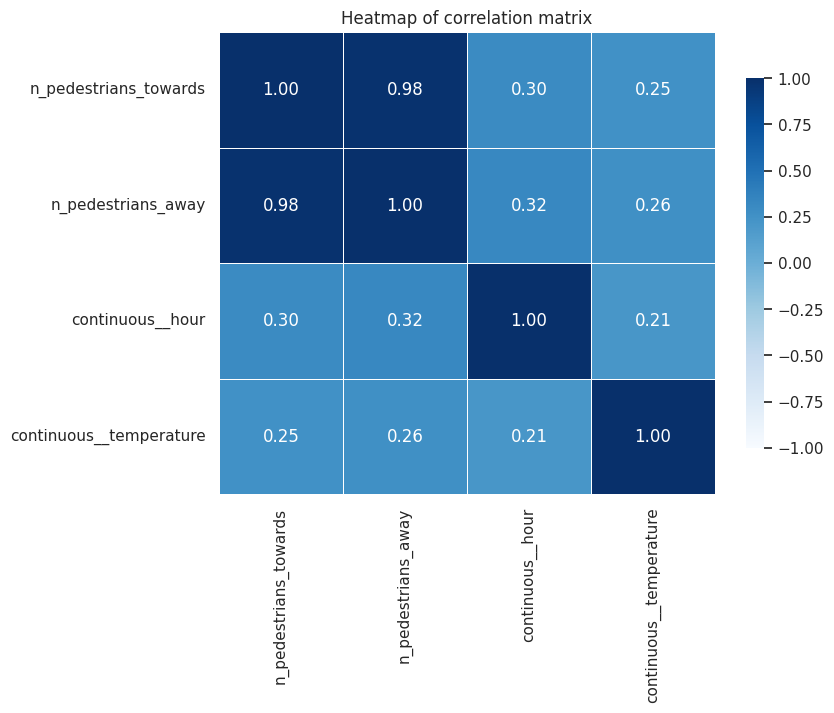

In [50]:
# Plot heat map between target variables and continuous variables
import scipy.stats as stats
import seaborn as sns

df_combined = pd.concat([y, X_transformed_df[['continuous__hour', 'continuous__temperature']]], axis=1)

# Calculate correlation matrix
corr_matrix = df_combined.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap="Blues",  # Setzt die Farben auf verschiedene Blautöne
    fmt=".2f", 
    linewidths=0.5, 
    vmin=-1, vmax=1,  # Sicherstellen, dass die Farbskala symmetrisch ist
    cbar_kws={'shrink': 0.8}  # Verkleinert die Farbskala
)

plt.title("Heatmap of correlation matrix")
plt.savefig(f"Heatmap_cont_features_target_variables.png", dpi=300, bbox_inches="tight")
plt.show()

In [51]:
from scipy.stats import chi2_contingency

y_binned = y.apply(lambda col: pd.qcut(col, q=4, labels=False))  # Binning into 4 equally sized groups

for target in y_binned.columns:
    print(f"\nChi-square test for target variable: {target}\n" + "-"*50)

    for cat_var in X.columns:
        if cat_var not in ["continuous__hour", "continuous__temperature"]:  # Ensure only categorical variables are used
            contingency_table = pd.crosstab(X[cat_var], y_binned[target])  # Create contingency table

            chi2, p, dof, expected = chi2_contingency(contingency_table)  # Perform Chi-square test
            
            print(f"\nVariable: {cat_var}")
            print(f"Chi²-score: {chi2:.2f}, p-value: {p:.5f}")
            if p < 0.05:
                print("→ Significant dependency between this variable and the target variable.")
            else:
                print("→ No significant dependency.")


Chi-square test for target variable: n_pedestrians_towards
--------------------------------------------------

Variable: streetname
Chi²-score: 4209.20, p-value: 0.00000
→ Significant dependency between this variable and the target variable.

Variable: hour
Chi²-score: 108355.68, p-value: 0.00000
→ Significant dependency between this variable and the target variable.

Variable: weekday
Chi²-score: 4781.85, p-value: 0.00000
→ Significant dependency between this variable and the target variable.

Variable: n_pedestrians_towards
Chi²-score: 239181.00, p-value: 0.00000
→ Significant dependency between this variable and the target variable.

Variable: n_pedestrians_away
Chi²-score: 183442.01, p-value: 0.00000
→ Significant dependency between this variable and the target variable.

Variable: temperature
Chi²-score: 10092.75, p-value: 0.00000
→ Significant dependency between this variable and the target variable.

Variable: weather_condition
Chi²-score: 27148.45, p-value: 0.00000
→ Significa

### Get Feature Importances Based on Model Type

In [52]:
# Model-specific feature importance

pipeline.get_feature_importances()

{'average':                                               Feature  Importance
 0                                    continuous__hour      1287.0
 1                             continuous__temperature      1090.0
 40       categorical__onehot__holiday_with_weekends_0       400.5
 25              categorical__onehot__weekday_Saturday       302.0
 3   categorical__onehot__streetname_Schoenbornstrasse       253.5
 26                categorical__onehot__weekday_Sunday       234.0
 6                      categorical__onehot__year_2020       228.5
 23                categorical__onehot__weekday_Friday       226.5
 22                      categorical__onehot__month_12       222.5
 5                      categorical__onehot__year_2019       217.0
 34  categorical__onehot__weather_condition_partly-...       193.0
 4      categorical__onehot__streetname_Spiegelstrasse       188.0
 9                      categorical__onehot__year_2023       187.5
 24                categorical__onehot__weekday_Mon

### Inspecting the Solution Dataset

In [53]:
# Create test_df with solution of public leaderboard

solution_df = pd.read_csv(f"{ftwue_path}/solutionPublicLeaderboard.csv")

merged_df = pd.merge(test_df, solution_df[['id', 'n_pedestrians', 'n_pedestrians_towards', 'n_pedestrians_away']], 
                     on='id', how='left')

merged_df.to_csv('solution_merged_output.csv', index=False)

# Show the merged dataframe
merged_df.head()

,id,streetname,city,date,hour,weekday,temperature,weather_condition,incidents,collection_type,...,schools_count,restaurants_count,healthcare_count,special_features_count,tram_access,pedestrian_zone,market_place,n_pedestrians,n_pedestrians_towards,n_pedestrians_away
0,Schoenbornstrasse_2024-09-16_0,Schoenbornstrasse,Wuerzburg,2024-09-16,0,Monday,12,cloudy,no_incident,measured,...,1,2,1,2,1,0,1,19.0,6.0,13.0
1,Schoenbornstrasse_2024-09-16_1,Schoenbornstrasse,Wuerzburg,2024-09-16,1,Monday,12,cloudy,no_incident,measured,...,1,2,1,2,1,0,1,15.0,8.0,7.0
2,Schoenbornstrasse_2024-09-16_2,Schoenbornstrasse,Wuerzburg,2024-09-16,2,Monday,10,rain,no_incident,measured,...,1,2,1,2,1,0,1,7.0,5.0,2.0
3,Schoenbornstrasse_2024-09-16_3,Schoenbornstrasse,Wuerzburg,2024-09-16,3,Monday,10,rain,no_incident,measured,...,1,2,1,2,1,0,1,2.0,0.0,2.0
4,Schoenbornstrasse_2024-09-16_4,Schoenbornstrasse,Wuerzburg,2024-09-16,4,Monday,10,rain,no_incident,measured,...,1,2,1,2,1,0,1,6.0,1.0,5.0


In [54]:
# Check timeframe for feature interpretation
print("Min Date:", merged_df['date'].min())
print("Max Date:", merged_df['date'].max())

Min Date: 2024-09-16
Max Date: 2024-09-29


## Appendix

### Check Presence of Events in the Test Dataset

In [55]:
# Get the min and max dates from merged_df
min_date = merged_df['date'].min()
max_date = merged_df['date'].max()

# Filter one_day_events based on the date range
filtered_one_day_events = one_day_events[(one_day_events['date'] >= min_date) & (one_day_events['date'] <= max_date)]

# Filter multi_day_events based on the date range
filtered_multi_day_events = multi_day_events[
    (multi_day_events['end_date'] >= min_date) & (multi_day_events['start_date'] <= max_date)
]

print("Entries from one_day_events within the date range:")
print(filtered_one_day_events)

print("\nEntries from multi_day_events within the date range:")
print(filtered_multi_day_events)


Entries from one_day_events within the date range:
Empty DataFrame
Columns: [date, event]
Index: []

Entries from multi_day_events within the date range:
Empty DataFrame
Columns: [start_date, end_date, event]
Index: []


### Check Presence of Holidays with Adjacent Weekends in the Test Dataset

In [56]:
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')  # Convert to datetime, handle errors as NaT

# Apply the add_holiday_with_weekends function to the merged dataframe
holiday_with_weekends = add_holiday_with_weekends(merged_df)

# Filter holiday_with_weekends based on the date range
filtered_holiday_with_weekends = holiday_with_weekends[
    (holiday_with_weekends['date'] >= min_date) & (holiday_with_weekends['date'] <= max_date)
]

# Filter the rows where 'holiday_with_weekends' is True
filtered_holiday_with_weekends_true = filtered_holiday_with_weekends[filtered_holiday_with_weekends['holiday_with_weekends'] == True]

# Select 'id' and 'holiday_with_weekends' columns
filtered_holiday_with_weekends_true = filtered_holiday_with_weekends_true[['id', 'holiday_with_weekends']]

print("Entries from holiday_with_weekends within the date range where holiday_with_weekends is True:")
filtered_holiday_with_weekends_true

Entries from holiday_with_weekends within the date range where holiday_with_weekends is True:


,id,holiday_with_weekends
96,Schoenbornstrasse_2024-09-20_0,True
97,Schoenbornstrasse_2024-09-20_1,True
98,Schoenbornstrasse_2024-09-20_2,True
99,Schoenbornstrasse_2024-09-20_3,True
100,Schoenbornstrasse_2024-09-20_4,True
...,...,...
499,Kaiserstrasse_2024-09-22_19,True
500,Kaiserstrasse_2024-09-22_20,True
501,Kaiserstrasse_2024-09-22_21,True
502,Kaiserstrasse_2024-09-22_22,True


### Optional: Saving and Reloading of Model PKL Files

In [57]:
# Save the pipeline for future use
# pipeline.save_pipeline('pedestrian_model_pipeline_test.pkl')

# To load the model in the future:
# pipeline.load_pipeline('pedestrian_model_pipeline.pkl')

### Save requirements.txt

In [58]:
# !pip freeze > requirements.txt